In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas

In [2]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit

In [22]:
import matplotlib.pyplot as plt

In [3]:
client = CryptoHistoricalDataClient()

In [4]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame(amount=15, unit=TimeFrameUnit('Min')),
    #timeframe=TimeFrame.Minute,
    start="2022-05-18",
    end="2023-05-18"
)

btc_bars = client.get_crypto_bars(request_params=request_params)

#print(btc_bars["BTC/USD"])

dates = []
stats = []
for item in btc_bars["BTC/USD"]:
    dates.append(dict(item)['timestamp'])
    
    temp_stats = []
    for key, value in dict(item).items():
        if key not in ['timestamp', 'symbol']:
            temp_stats.append(value) 
    stats.append(temp_stats)

print(len(stats))
    
data = torch.tensor(stats)
print(data.shape)


35031
torch.Size([35031, 7])


In [28]:
f = open('data/btc_minute_23-05-18_24-05-18.csv', 'a')

for item in data:
    
    string = ', '.join(str(list(item))) + '\n'

    f.write(string)

TypeError: float() argument must be a string or a real number, not 'list'

In [46]:
time_period = 30
feature_space = 7
output_size = 3 #[down, no change, up]
batch_size = 16

device = 'cuda' if torch.cuda.is_available() else 'mps'
print(torch.cuda.is_available())

torch.manual_seed(0)

True


In [47]:
class BTCDataset(Dataset):

    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        random_index = torch.randint(0, len(self.data) - time_period, size=(1,))
        return self.data[random_index:random_index+time_period+1]
    
    def __len__(self):
        return len(self.data)

In [48]:
dataset = BTCDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [142]:
for item in dataloader:
    print(item.shape)
    break

torch.Size([16, 61, 7])


In [49]:
class FeedForward(nn.Module):
    
    def __init__(self, dropout, embedding_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.ReLU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
    
class Head(nn.Module):
    
    def __init__(self, dropout, embedding_dim, head_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        #self.register_buffer('tril', torch.tril(torch.ones(time_period, time_period)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) #(B, T, head_size)
        q = self.query(x) #(B, T, head_size)
        att = q @ k.transpose(-2, -1) * (k.size(-1) ** -0.5) # Want (B, T, T) where there is a value for how each token relates to each other token
        # want k to be (B, C, T) k.transpose(-2, -1) swaps the last 2 dimensions, giving (B, C, T)
        #att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1) 
        att = self.dropout(att)
        v = self.value(x)
        out = att @ v
        return out

class MultiHeadAttention(nn.Module):
    
    def __init__(self, dropout, embedding_dim, head_size, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([Head(dropout, embedding_dim, head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class Block(nn.Module):

    def __init__(self, dropout, embedding_dim, head_size, num_heads):
        super().__init__()
        self.self_att = MultiHeadAttention(dropout, embedding_dim, head_size, num_heads)
        self.ffwd = FeedForward(dropout, embedding_dim)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x = x + self.self_att(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class Transformer(nn.Module):

    def __init__(self, dropout, embedding_dim, num_heads, head_size, num_layers):
        super().__init__()
        self.data_embedding = nn.Linear(feature_space, embedding_dim)
        self.position_embedding = nn.Embedding(time_period, embedding_dim)
        self.blocks = nn.Sequential(*[Block(dropout, embedding_dim, head_size, num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, output_size)
    
    def forward(self, x):
        #B, T = x.shape

        data_embeddings = self.data_embedding(x)
        positional_embeddings = self.position_embedding(torch.arange(time_period, device=device))
        
        x = data_embeddings + positional_embeddings
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        return logits


In [57]:
model = Transformer(dropout=0.2, embedding_dim=256, num_heads=64, head_size=4, num_layers=64).to(device) #50M param - 256, 64, 4, 64   100k - 32, 8, 4, 8
loss_function = F.cross_entropy
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)

num_epochs = 1

In [58]:
threshold = 0.0005
def get_targets(chunk):
    # returns 1 hot encoding of whether the stock goes up or down
    target = chunk[:, time_period, :]
    chunk_real = chunk[:, :time_period, :]
    
    real_targets = []
    for i in range(len(chunk_real)):
        real_price = chunk_real[i, -1, 3]
        target_price = target[i, 3]
        if target_price > real_price*(1 + threshold):
            # move up
            real_targets.append([0, 0, 1])
        elif target_price < real_price*(1 - threshold):
            # move down
            real_targets.append([1, 0, 0])
        else:
            # no change
            real_targets.append([0, 1, 0])

    return torch.tensor(real_targets, device=device, dtype=torch.float32)

def normalize_features(real_chunk):
    B, T, C = real_chunk.shape
    #for j in range(time_period):
    for j in range(B):
    #    for i in range(feature_space):
        for i in range(C):
            # this current normalizes across the entire batch
            # i think we want to normalize each feature across the entire time period, per batch
            #feature_mean = sum(real_chunk[:, j, i]) / batch_size
            #feature_stdev = torch.std(real_chunk[:, j, i])
            #real_chunk[:, j, i] -= feature_mean
            #real_chunk[:, j, i] /= feature_stdev

            feature_mean = sum(real_chunk[j, :, i]) / T
            feature_stdev = torch.std(real_chunk[j, :, i])
            real_chunk[j, :, i] -= feature_mean
            real_chunk[j, :, i] /= feature_stdev

    return real_chunk
            

In [59]:
print(sum(p.numel() for p in model.parameters()))

losses = []
iteration = 0
for epoch in range(num_epochs):
    
    for chunk in dataloader:        
        targets = get_targets(chunk)
        chunk_real = chunk[:, :time_period, :].to(device)
        normalized_chunk = normalize_features(chunk_real)
        #print(normalized_chunk[:, 0, 0])
        logits = model(normalized_chunk)
        #logit_probs = F.softmax(logits[:, -1, :], dim=-1)
        #logits = F.softmax(logits[:, -1, :], dim=-1)
       # loss = loss_function(logit_probs, targets)
        loss = loss_function(input=logits[:, -1, :], target=targets)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if iteration % 250 == 0:
            print(iteration, loss.item())
        
        iteration += 1

    torch.save(model, 'model/btc15train')

torch.save(model, 'model/btc15train')


print(iteration)

        

50506499
0 1.1625032424926758
250 1.0665940046310425
500 0.9752467274665833
750 1.0623825788497925
1000 1.1164590120315552
1250 1.1819560527801514
1500 1.0778220891952515
1750 1.0373806953430176
2000 1.062254548072815
2190


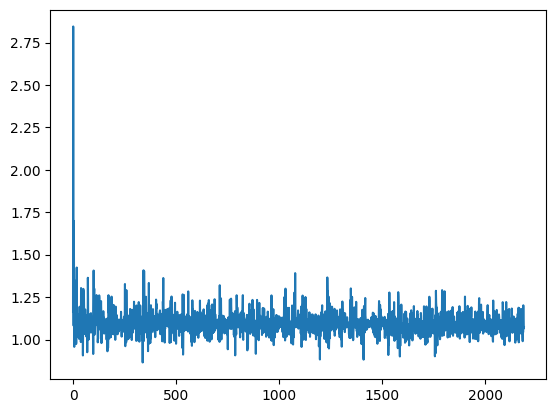

In [60]:
plt.plot(losses[:len(losses)-1])
plt.show() #6.4M

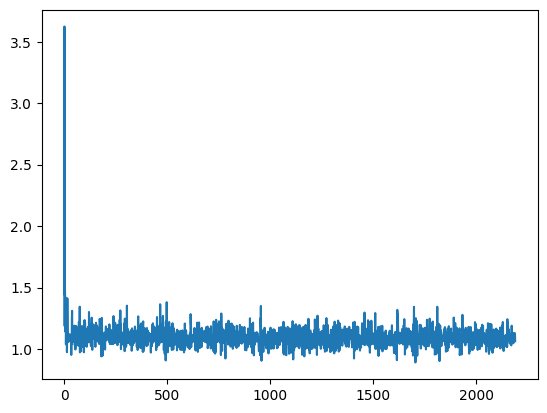

In [69]:
plt.plot(losses[:len(losses)-1])
plt.show() #50M

In [70]:
torch.save(model, 'model/btc15_50M')

In [61]:
#model.load_state_dict(torch.load('model/btc15'))
model.eval()

Transformer(
  (data_embedding): Linear(in_features=7, out_features=256, bias=True)
  (position_embedding): Embedding(30, 256)
  (blocks): Sequential(
    (0): Block(
      (self_att): MultiHeadAttention(
        (heads): ModuleList(
          (0-63): 64 x Head(
            (key): Linear(in_features=256, out_features=4, bias=False)
            (query): Linear(in_features=256, out_features=4, bias=False)
            (value): Linear(in_features=256, out_features=4, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((256,), eps=1e-05, 

In [25]:
# get previous data, run a 60 second thing through it, buy at the close, sell at the next close, evaluate
# how much money was made

request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame(amount=15, unit=TimeFrameUnit('Min')),
    #timeframe=TimeFrame.Minute,
    start="2023-05-22",
    end="2024-05-22"
)

btc_bars = client.get_crypto_bars(request_params=request_params)

dates = []
stats = []
for item in btc_bars["BTC/USD"]:
    dates.append(dict(item)['timestamp'])
    
    temp_stats = []
    for key, value in dict(item).items():
        if key not in ['timestamp', 'symbol']:
            temp_stats.append(value) 
    stats.append(temp_stats)
    
testing_data = torch.tensor(stats, device=device)

In [26]:
#print(testing_data[0]) #[open, high, low, close]
#print(testing_data[1]) compare previous close to next close

for i in range(10):
    print(dates[i], stats[i])

print(dates[-1], stats[-1])

2023-05-22 00:00:00+00:00 [26768.54, 26809.005405, 26762.0034639, 26797.3479, 15.68459, 392.0, 26786.535498]
2023-05-22 00:15:00+00:00 [26798.86, 27465.3422301955, 26701.08, 26720.1929, 25.9325, 770.0, 26740.341693]
2023-05-22 00:30:00+00:00 [26718.57, 26718.57, 26574.57, 26649.7983, 106.87889, 2329.0, 26635.65507]
2023-05-22 00:45:00+00:00 [26653.1785, 26703.568832, 26611.39, 26678.327005015, 39.681799919, 973.0, 26655.359164]
2023-05-22 01:00:00+00:00 [26681.64, 26717.33, 26615.14171475, 26644.2935, 28.84278, 874.0, 26661.359219]
2023-05-22 01:15:00+00:00 [26647.54, 26700.754978425, 26615.066755, 26688.0598684, 44.39834, 947.0, 26674.847663]
2023-05-22 01:30:00+00:00 [26684.26, 26696.4424315, 26632.07, 26677.898455, 39.76279, 746.0, 26673.051045]
2023-05-22 01:45:00+00:00 [26667.24, 26675.909569255, 26584.93, 26606.95, 82.314944819, 2481.0, 26627.321135]
2023-05-22 02:00:00+00:00 [26605.3, 26647.27, 26556.7, 26636.78468345, 94.76774, 3546.0, 26596.940138]
2023-05-22 02:15:00+00:00 [2

In [62]:
cash_values = [(1000,-1)]
iterations = 0
num_sells = 0
num_buys = 0

frequencies = {}
prob_threshold = 0.5

with torch.no_grad():
    for bar in range(len(testing_data) - time_period):
    #for bar in range(24918, 24918+6):
        cash = cash_values[-1][0]
        test_context = testing_data[bar:bar+time_period].view(1, time_period, feature_space).detach().clone()
        test_target = testing_data[bar+time_period].detach().clone()
        #print(test_context[0, -1], test_target)
        buying_price = test_context[0, -1, 3].detach().clone().cpu().numpy() # closing price
        selling_price = test_target[3].detach().clone().cpu().numpy() #closing price

        #print(buying_price, selling_price)

        normalized_context = normalize_features(test_context)

        logits = model(normalized_context)
        #if (iterations+1) % 39 == 0:
            #print(F.softmax(logits[0, -1], dim=-1))
        #    break

        decision = torch.argmax(logits[0, -1]).detach().clone()
        
        if (abs(buying_price-selling_price)/buying_price > 0.02):
            decision = 1
        
        if decision == 2:
            # buy signal
            #print(selling_price-buying_price)
    
            shares = cash / buying_price
    
            probabilities = F.softmax(logits[0, -1], dim=-1)
            highest_prob = torch.max(probabilities).detach().clone().cpu()
            if highest_prob < prob_threshold:
                continue
            money_made = (selling_price - buying_price) * shares
            if highest_prob in frequencies:
                frequencies[highest_prob] += money_made
            else:
                frequencies[highest_prob] = money_made

            
            cash = 0 + selling_price * shares
            num_buys += 1

            

        elif decision == 1:
            # do nothing
            pass
        elif decision == 0:
            # sell signal
            #cash += (buying_price-selling_price) * (cash / buying_price)
            shares = cash / buying_price
            money_made_selling = cash
            buying_back = shares * selling_price
            

            probabilities = F.softmax(logits[0, -1], dim=-1)
            highest_prob = torch.max(probabilities).detach().clone().cpu()
            if highest_prob < prob_threshold:
                continue
            money_made = (money_made_selling - buying_back)
            if highest_prob in frequencies:
                frequencies[highest_prob] += money_made
            else:
                frequencies[highest_prob] = money_made

            cash += (money_made_selling - buying_back)
            #print(money_made_selling - buying_back)
            num_sells += 1


        else:
            # error
            print("Bad")
        
        #print(cash)
        cash_values.append((cash,iterations))
        iterations += 1
        

        

print(f'Iterations: {iterations}, buys: {num_buys}, sells: {num_sells}')

KeyboardInterrupt: 

[(1000, -1), (1000, 0), (1000, 1), (1000, 2), (1000, 3), (1000, 4), (1000, 5), (1000, 6), (1000, 7)]


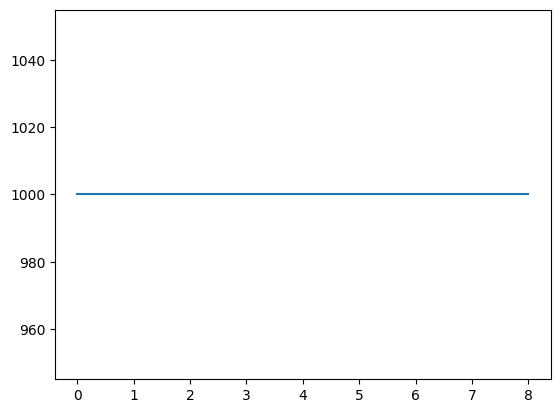

In [63]:
print(cash_values)
show_vals = [pair[0] for pair in cash_values]
plt.plot(show_vals)
plt.show()

In [33]:
print(testing_data[24918+time_period])
print(testing_data[24919+time_period])
print(testing_data[24920+time_period])
print(testing_data[24921+time_period])
print(testing_data[24922+time_period])
print(testing_data[24923+time_period])

tensor([2.2923e+04, 2.2935e+04, 2.2910e+04, 2.2919e+04, 1.6346e+01, 5.2300e+02,
        2.2926e+04], device='cuda:0')
tensor([2.2919e+04, 2.2932e+04, 2.2883e+04, 2.2883e+04, 5.2288e+00, 3.8000e+02,
        2.2897e+04], device='cuda:0')
tensor([2.2894e+04, 2.2900e+04, 2.2894e+04, 2.2900e+04, 9.3334e-03, 3.0000e+00,
        2.2900e+04], device='cuda:0')
tensor([2.3766e+04, 2.3766e+04, 2.1978e+04, 2.3766e+04, 5.1341e-02, 1.2000e+01,
        2.3544e+04], device='cuda:0')
tensor([2.2827e+04, 2.3766e+04, 2.1978e+04, 2.3766e+04, 1.5856e-02, 4.0000e+00,
        2.3173e+04], device='cuda:0')
tensor([2.1978e+04, 2.3766e+04, 2.1978e+04, 2.1978e+04, 2.4003e-02, 4.0000e+00,
        2.2596e+04], device='cuda:0')


In [43]:
# next steps: normalize/scale the features,,,,???? center around 0 and 1 STDEV, should be a cool way to do this in pytorch
# rewrite the code to be more clean

#back test this on some new data
print(cash_values[-1])

(1097.4244869283111, 3418)


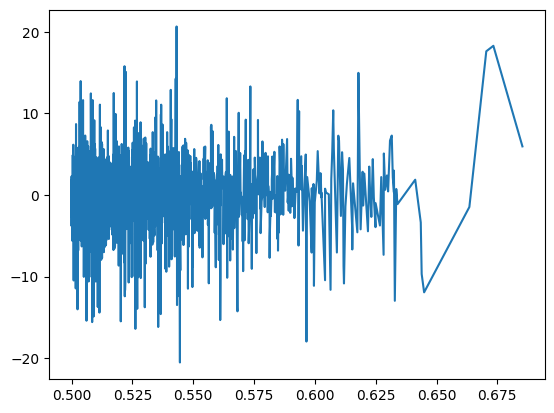

In [44]:
# determine which trades are making the most money, and which are losing the most money
# map a histrogram of money made vs probability of that trade
sorted_freq = sorted(frequencies.items())

x,y = zip(*sorted_freq)
plt.plot(x,y)
plt.show()

In [45]:
print(sum(y)/ len(y))

0.04014193940185761
